In [27]:
import pandas as pd
import numpy as np
import pickle
import csv

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


import matplotlib.pyplot as plt
import seaborn as sns

import os
import copy
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
sales_df = pd.read_csv("train.csv")
sales_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [4]:
sales_df.isnull().sum()

,0
date,0
store,0
item,0
sales,0


In [5]:
#we dont need the shop or type of items sold so we are gonna remove those columns
sales_df = sales_df.drop(['store', 'item'], axis=1)
sales_df.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [6]:
#changing datatype of date
sales_df['date'] = pd.to_datetime(sales_df['date'])
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [7]:
#now converting date to month period instead of day period
sales_df['date'] = sales_df['date'].dt.to_period('M')
monthly_sales_df = sales_df.groupby('date').sum().reset_index()
monthly_sales_df['date'] = monthly_sales_df['date'].dt.to_timestamp()  #timestamp format

monthly_sales_df.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


<function matplotlib.pyplot.show(close=None, block=None)>

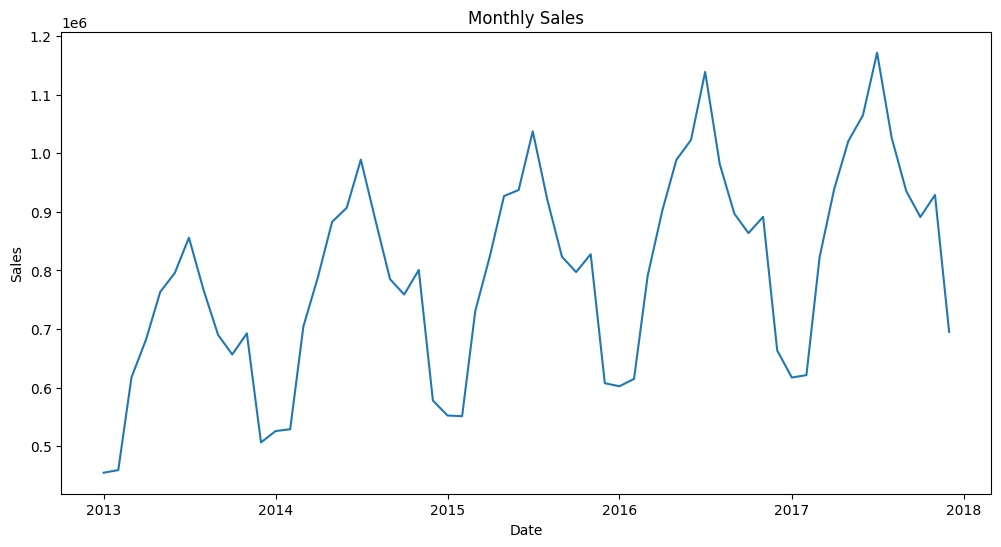

In [8]:
plt.figure(figsize=(12,6))
plt.plot(monthly_sales_df.date, monthly_sales_df.sales)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales')
plt.show

In [9]:
month_df = copy.deepcopy(monthly_sales_df)
month_df['month'] = monthly_sales_df['date'].dt.month
month = month_df.groupby('month')['sales'].sum().reset_index()
month

,month,sales
0,1,2753149
1,2,2776177
2,3,3666182
3,4,4136467
4,5,4582437
5,6,4726911
6,7,5192393
7,8,4580655
8,9,4130457
9,10,3967520


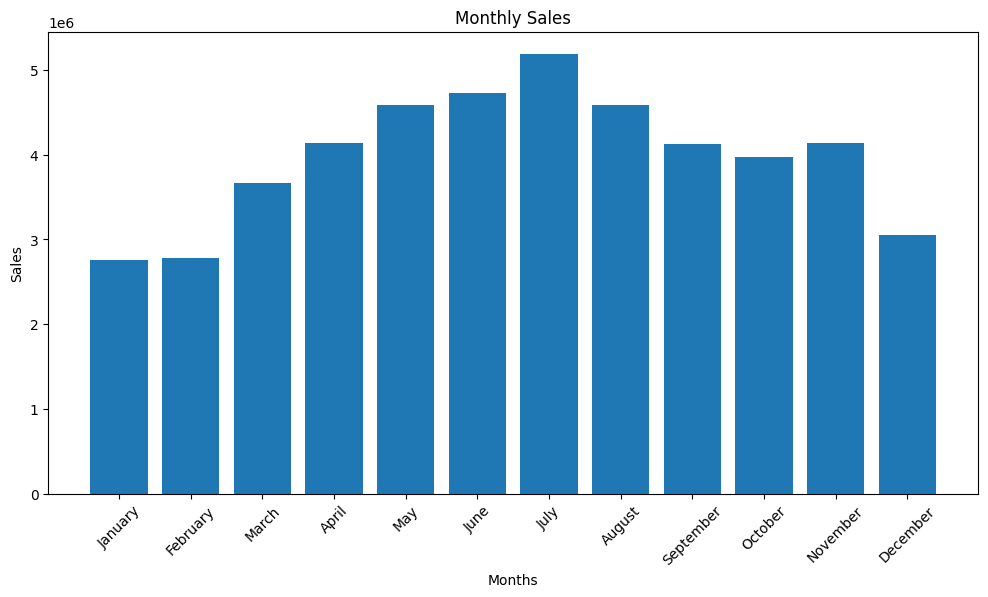

In [10]:
plt.figure(figsize=(12,6))
plt.bar(month['month'], month['sales'])

month_labels = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']
plt.xticks(ticks=np.arange(1, 13, 1), labels=month_labels, rotation=45)

plt.xlabel('Months')
plt.ylabel('Sales')
plt.title("Monthly Sales")

plt.show()

In [11]:
#for difference in sales of each month of each year
monthly_sales_df['sales_diff'] = monthly_sales_df['sales'].diff()
monthly_sales_df.head()

,date,sales,sales_diff
0,2013-01-01,454904,NaN
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0


<function matplotlib.pyplot.show(close=None, block=None)>

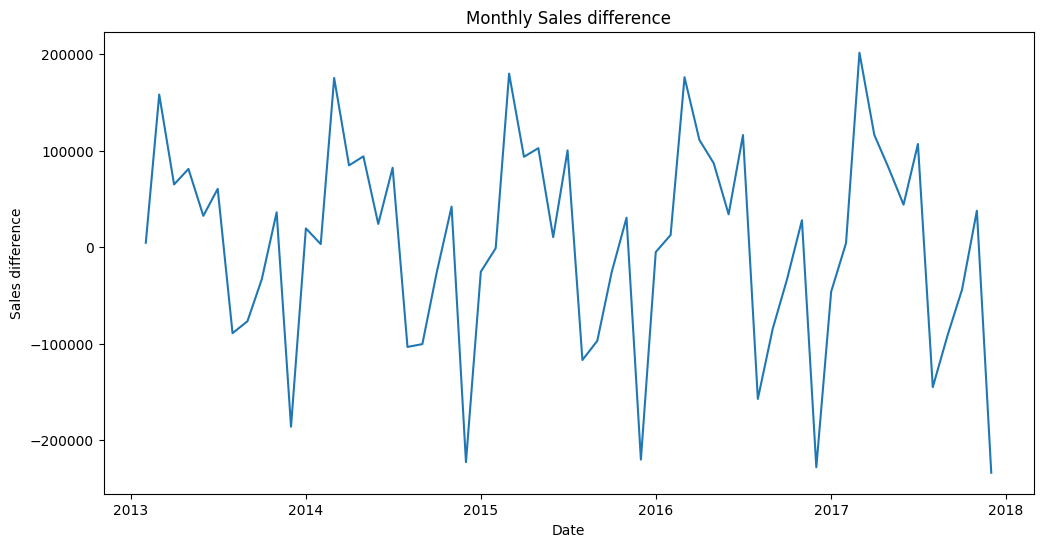

In [12]:
plt.figure(figsize=(12,6))
plt.plot(monthly_sales_df.date, monthly_sales_df.sales_diff)
plt.xlabel('Date')
plt.ylabel('Sales difference')
plt.title('Monthly Sales difference')
plt.show

In [13]:
df = monthly_sales_df.drop(['date', 'sales'], axis = 1)
df.head()

,sales_diff
0,NaN
1,4513.0
2,157965.0
3,64892.0
4,80968.0


In [14]:
#preparing the data
for i in range(1,13):
  col_name = 'month_' + str(i)
  df[col_name] = df['sales_diff'].shift(i)
df = df.dropna().reset_index(drop=True)

df.head()

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


Certainly! Let's break down the example in more detail, showing exactly how the lagged features are created and why they look the way they do.

---

### **Original Data**

Suppose we start with a DataFrame that has just one column, `sales_diff`:

| **Index** | **sales_diff** |
|-----------|----------------|
| 0         | 100            |
| 1         | 120            |
| 2         | 140            |
| 3         | 160            |
| 4         | 180            |

---

### **After Adding Lagged Features**

When you execute the `for` loop:
```python
for i in range(1, 13):
    col_name = 'month_' + str(i)
    df[col_name] = df['sales_diff'].shift(i)
```

The `shift(i)` function moves values in the `sales_diff` column **downward by `i` rows** to create lagged features. Here’s how it works for a few iterations:

#### **1st Iteration (i = 1):**
- Create a column called `month_1`.
- Add `df['sales_diff'].shift(1)` to this column:
  - Each value in `sales_diff` is shifted down by 1 row.

| **Index** | **sales_diff** | **month_1** |
|-----------|----------------|-------------|
| 0         | 100            | NaN         |
| 1         | 120            | 100         |
| 2         | 140            | 120         |
| 3         | 160            | 140         |
| 4         | 180            | 160         |

---

#### **2nd Iteration (i = 2):**
- Create a column called `month_2`.
- Add `df['sales_diff'].shift(2)` to this column:
  - Each value in `sales_diff` is shifted down by 2 rows.

| **Index** | **sales_diff** | **month_1** | **month_2** |
|-----------|----------------|-------------|-------------|
| 0         | 100            | NaN         | NaN         |
| 1         | 120            | 100         | NaN         |
| 2         | 140            | 120         | 100         |
| 3         | 160            | 140         | 120         |
| 4         | 180            | 160         | 140         |

---

#### **3rd Iteration (i = 3):**
- Create a column called `month_3`.
- Add `df['sales_diff'].shift(3)` to this column:
  - Each value in `sales_diff` is shifted down by 3 rows.

| **Index** | **sales_diff** | **month_1** | **month_2** | **month_3** |
|-----------|----------------|-------------|-------------|-------------|
| 0         | 100            | NaN         | NaN         | NaN         |
| 1         | 120            | 100         | NaN         | NaN         |
| 2         | 140            | 120         | 100         | NaN         |
| 3         | 160            | 140         | 120         | 100         |
| 4         | 180            | 160         | 140         | 120         |

---

### **Final Dataset After All Iterations**
After the loop completes, you have lagged columns (`month_1` to `month_12`), but many rows at the top will contain `NaN` values because there is no earlier data to fill them. For example:

| **Index** | **sales_diff** | **month_1** | **month_2** | **month_3** | ... | **month_12** |
|-----------|----------------|-------------|-------------|-------------|-----|--------------|
| 0         | 100            | NaN         | NaN         | NaN         | ... | NaN          |
| 1         | 120            | 100         | NaN         | NaN         | ... | NaN          |
| 2         | 140            | 120         | 100         | NaN         | ... | NaN          |
| 3         | 160            | 140         | 120         | 100         | ... | NaN          |
| 4         | 180            | 160         | 140         | 120         | ... | NaN          |

---

### **After Dropping NaN Values**
Finally, when you use `df.dropna()`, all rows with any `NaN` values are removed. In this example, the top 12 rows will be dropped because the lagged columns `month_1` to `month_12` require 12 previous rows of data to be filled. The final DataFrame looks like this:

| **Index** | **sales_diff** | **month_1** | **month_2** | **month_3** | ... | **month_12** |
|-----------|----------------|-------------|-------------|-------------|-----|--------------|
| 12        | (value)        | (value)     | (value)     | (value)     | ... | (value)      |

---

### **Purpose**
- Each row in the final DataFrame includes the `sales_diff` for the current period and the lagged `sales_diff` values for the last 12 periods.
- This structure is ideal for models like regression or time-series forecasting, where past values are used to predict future outcomes.

Let me know if you have further questions!Certainly! Let's break down the example in more detail, showing exactly how the lagged features are created and why they look the way they do.

---

### **Original Data**

Suppose we start with a DataFrame that has just one column, `sales_diff`:

| **Index** | **sales_diff** |
|-----------|----------------|
| 0         | 100            |
| 1         | 120            |
| 2         | 140            |
| 3         | 160            |
| 4         | 180            |

---

### **After Adding Lagged Features**

When you execute the `for` loop:
```python
for i in range(1, 13):
    col_name = 'month_' + str(i)
    df[col_name] = df['sales_diff'].shift(i)
```

The `shift(i)` function moves values in the `sales_diff` column **downward by `i` rows** to create lagged features. Here’s how it works for a few iterations:

#### **1st Iteration (i = 1):**
- Create a column called `month_1`.
- Add `df['sales_diff'].shift(1)` to this column:
  - Each value in `sales_diff` is shifted down by 1 row.

| **Index** | **sales_diff** | **month_1** |
|-----------|----------------|-------------|
| 0         | 100            | NaN         |
| 1         | 120            | 100         |
| 2         | 140            | 120         |
| 3         | 160            | 140         |
| 4         | 180            | 160         |

---

#### **2nd Iteration (i = 2):**
- Create a column called `month_2`.
- Add `df['sales_diff'].shift(2)` to this column:
  - Each value in `sales_diff` is shifted down by 2 rows.

| **Index** | **sales_diff** | **month_1** | **month_2** |
|-----------|----------------|-------------|-------------|
| 0         | 100            | NaN         | NaN         |
| 1         | 120            | 100         | NaN         |
| 2         | 140            | 120         | 100         |
| 3         | 160            | 140         | 120         |
| 4         | 180            | 160         | 140         |

---

#### **3rd Iteration (i = 3):**
- Create a column called `month_3`.
- Add `df['sales_diff'].shift(3)` to this column:
  - Each value in `sales_diff` is shifted down by 3 rows.

| **Index** | **sales_diff** | **month_1** | **month_2** | **month_3** |
|-----------|----------------|-------------|-------------|-------------|
| 0         | 100            | NaN         | NaN         | NaN         |
| 1         | 120            | 100         | NaN         | NaN         |
| 2         | 140            | 120         | 100         | NaN         |
| 3         | 160            | 140         | 120         | 100         |
| 4         | 180            | 160         | 140         | 120         |

---

### **Final Dataset After All Iterations**
After the loop completes, you have lagged columns (`month_1` to `month_12`), but many rows at the top will contain `NaN` values because there is no earlier data to fill them. For example:

| **Index** | **sales_diff** | **month_1** | **month_2** | **month_3** | ... | **month_12** |
|-----------|----------------|-------------|-------------|-------------|-----|--------------|
| 0         | 100            | NaN         | NaN         | NaN         | ... | NaN          |
| 1         | 120            | 100         | NaN         | NaN         | ... | NaN          |
| 2         | 140            | 120         | 100         | NaN         | ... | NaN          |
| 3         | 160            | 140         | 120         | 100         | ... | NaN          |
| 4         | 180            | 160         | 140         | 120         | ... | NaN          |

---

### **After Dropping NaN Values**
Finally, when you use `df.dropna()`, all rows with any `NaN` values are removed. In this example, the top 12 rows will be dropped because the lagged columns `month_1` to `month_12` require 12 previous rows of data to be filled. The final DataFrame looks like this:

| **Index** | **sales_diff** | **month_1** | **month_2** | **month_3** | ... | **month_12** |
|-----------|----------------|-------------|-------------|-------------|-----|--------------|
| 12        | (value)        | (value)     | (value)     | (value)     | ... | (value)      |

---

### **Purpose**
- Each row in the final DataFrame includes the `sales_diff` for the current period and the lagged `sales_diff` values for the last 12 periods.
- This structure is ideal for models like regression or time-series forecasting, where past values are used to predict future outcomes.


In [15]:
#model building
train_data = df[:-12]
test_data = df[-12:]                            #most recent data used for testing
print("train data shape:", train_data.shape)
print("test data shape:", test_data.shape)

train data shape: (35, 13)
test data shape: (12, 13)


In [16]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

### Code Explanation: Scaling Data

```python
scaler = MinMaxScaler(feature_range=(-1, 1))  # Initialize MinMaxScaler with a range of -1 to 1
scaler.fit(train_data)                       # Fit the scaler to the training data
train_data = scaler.transform(train_data)    # Transform the training data using the scaler
test_data = scaler.transform(test_data)      # Transform the test data using the same scaler
```

This snippet normalizes the training and testing data using the **`MinMaxScaler`** from `sklearn.preprocessing`. Here's a detailed explanation:

---

### **1. Why Scaling?**
- **Purpose:** Many machine learning models (e.g., regression, neural networks) perform better when input features are on a similar scale. This prevents features with larger ranges from dominating the learning process.
- Scaling ensures consistent feature scaling, which can improve convergence speed and model accuracy.

---

### **2. MinMaxScaler**
The **`MinMaxScaler`** scales features to a specific range, specified by the `feature_range` argument.

- **Default Range:** `[0, 1]`.
- **Custom Range:** Here, it's set to `(-1, 1)`.
  - This ensures that all feature values fall within the range `-1` to `1`.

#### **Scaling Formula:**
For a feature \( x \):
\[
x_{\text{scaled}} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)} \times (\text{max\_range} - \text{min\_range}) + \text{min\_range}
\]
Where:
- \( \text{min}(x) \) and \( \text{max}(x) \): Minimum and maximum values in the feature.
- \( \text{max\_range} \) and \( \text{min\_range} \): The specified scaling range (here, `-1` and `1`).

---

### **3. Key Steps**

#### **Step 1: Fit the Scaler**
```python
scaler.fit(train_data)
```
- Computes the minimum and maximum values for each feature in the training data.
- These values are used to calculate the scaling parameters.

#### **Step 2: Transform the Data**
```python
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)
```
- Scales both the training and testing data using the parameters computed from the **training data**.
- It is important to fit the scaler only on the training data and apply it to both training and testing data. This avoids information leakage from the test set during model training.

---

### **4. Result**
After scaling:
- All values in `train_data` and `test_data` are scaled to fall within the range `(-1, 1)`.

---

### **Example**

#### Original Data (Hypothetical Values):
| Feature 1 | Feature 2 |
|-----------|-----------|
| 100       | 2000      |
| 150       | 2500      |
| 200       | 3000      |

#### Scaled Data (Range: -1 to 1):
| Feature 1 | Feature 2 |
|-----------|-----------|
| -1.0      | -1.0      |
|  0.0      |  0.0      |
|  1.0      |  1.0      |

---

### **Key Notes**
- Ensure that both `train_data` and `test_data` have consistent feature ranges.
- The scaler should always be fitted only on the training data to prevent data leakage.

Would you like help visualizing the scaled data or understanding the differences further?

In [17]:
X_train, y_train = train_data[:, 1:], train_data[:,0:1]
X_test , y_test = test_data[:, 1:], test_data[:,0:1]
y_train = y_train.ravel()                             #flattens multidimensional array into 1d array
y_test = y_test.ravel()
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (35, 12)
y_train shape: (35,)
X_test shape: (12, 12)
y_test shape: (12,)


This code splits the scaled dataset into **features (`X`)** and **target (`y`)** for both training and testing data. Here's an explanation of what each line does:

---

### **1. Splitting Features (`X`) and Target (`y`)**
```python
X_train, y_train = train_data[:, 1:], train_data[:, 0:1]
X_test, y_test = test_data[:, 1:], test_data[:, 0:1]
```
- The `[:, 1:]` and `[:, 0:1]` slicing is used to separate the columns:
  - **`train_data[:, 1:]`**:
    - Selects all rows (`:`) and all columns starting from index `1` (second column) to the end.
    - These columns are treated as the **features (`X`)**.
  - **`train_data[:, 0:1]`**:
    - Selects all rows (`:`) and only the first column (`0:1`).
    - This column is treated as the **target (`y`)**.
  - The same process is applied to `test_data`.

---

### **2. Flattening the Target Array**
```python
y_train = y_train.ravel()
y_test = y_test.ravel()
```
- **`ravel()`** flattens a multi-dimensional array into a 1D array:
  - Example:
    ```python
    y_train = [[100], [150], [200]]  # Shape: (3, 1)
    y_train.ravel()  # Output: [100, 150, 200] (Shape: (3,))
    ```

---

### **3. Printing Shapes**
```python
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
```
- This prints the dimensions of the feature and target arrays:
  - **`X_train.shape`**:
    - Number of rows: Number of samples in the training set.
    - Number of columns: Number of features in the training set.
  - **`y_train.shape`**:
    - Number of rows: Number of target values in the training set (should match `X_train` rows).
  - Similarly for `X_test` and `y_test`.

---

### **Example**
Suppose `train_data` and `test_data` look like this:
| Feature 1 | Feature 2 | Target |
|-----------|-----------|--------|
| 0.2       | 0.4       | 1.0    |
| 0.5       | 0.6       | 0.8    |
| 0.7       | 0.9       | 0.6    |

- **Splitting:**
  - `X_train`:
    ```
    [[0.4]
     [0.6]
     [0.9]]
    ```
  - `y_train`: `[0.2, 0.5, 0.7]`

- **Shapes:**
  - `X_train.shape`: `(3, 1)` (3 rows, 1 feature)
  - `y_train.shape`: `(3,)` (3 rows, 1D array)

---

### **Why This Splitting?**
- Machine learning models typically require:
  - **Features (`X`)**: Represent input variables.
  - **Target (`y`)**: Represent the output (dependent variable).
- Splitting ensures the input and output are clearly defined for training and testing.

Would you like to test this with real data or understand further?

In [18]:
sales_date = monthly_sales_df['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_date)

In [19]:
actual_sales = monthly_sales_df['sales'][-13:].to_list()
print(actual_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [20]:
#linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)

In [21]:
predict = predict.reshape(-1,1)
predict_test = np.concatenate((predict, X_test), axis=1) #this is a test set matrix that contains the predicted outputs as well as input features of the test data
predict_test = scaler.inverse_transform(predict_test)

In [22]:
result_list = []
for index in range(0, len(predict_test)):
  result_list.append(predict_test[index][0] + actual_sales[index])
predict_series = pd.Series(result_list, name = 'Linear predictions')                  #must remember this name
predict_df = predict_df.merge(predict_series, left_index = True, right_index = True)

In [23]:
predict_df

,date,Linear predictions
0,2017-01-01,6.479148e+05
1,2017-02-01,6.283374e+05
2,2017-03-01,8.195190e+05
3,2017-04-01,9.436391e+05
4,2017-05-01,1.033653e+06
5,2017-06-01,1.065286e+06
6,2017-07-01,1.201561e+06
7,2017-08-01,1.002123e+06
8,2017-09-01,9.415142e+05
9,2017-10-01,9.080646e+05


In [28]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear predictions'], monthly_sales_df['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear predictions'], monthly_sales_df['sales'][-12:]) #mean absolute error
lr_r2 = r2_score(predict_df['Linear predictions'], monthly_sales_df['sales'][-12:])
print("Mean Squared Error:", lr_mse)
print("Mean Absolute Error:", lr_mae)
print("r2 score:", lr_r2)

Mean Squared Error: 16221.272385416869
Mean Absolute Error: 12433.184266490736
r2 score: 0.9906152516380969


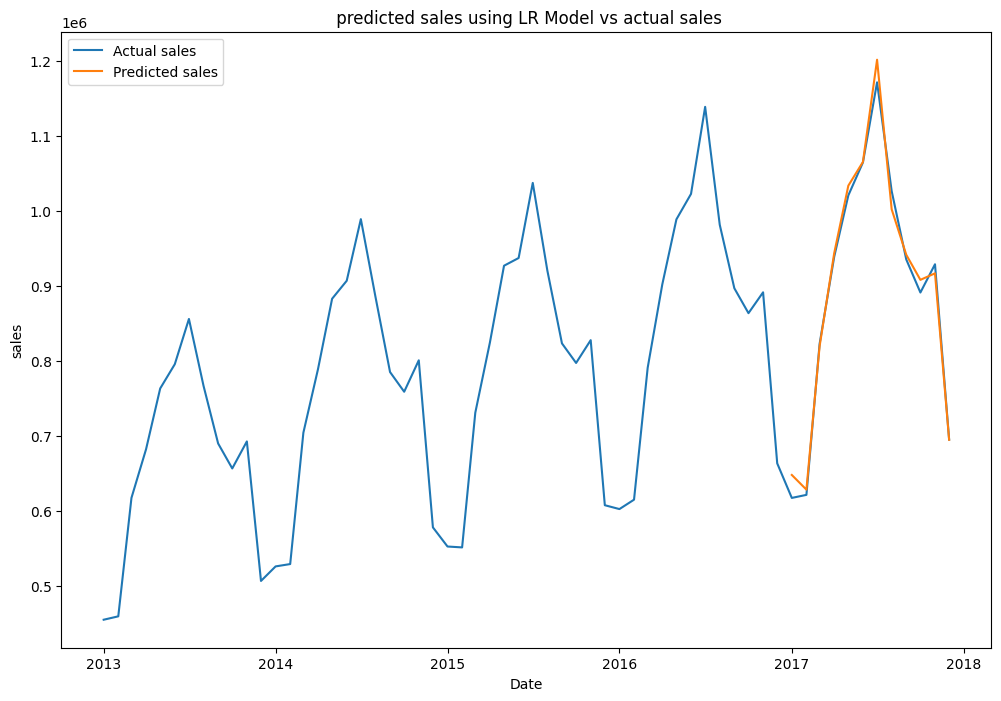

In [32]:
#predictions vs acutal values
plt.figure(figsize= (12, 8))

plt.plot(monthly_sales_df.date, monthly_sales_df.sales, label = 'Actual sales') #actual sales

plt.plot(predict_df['date'], predict_df['Linear predictions'], label = 'Predicted sales') #predicted sales
plt.xlabel('Date')
plt.ylabel('sales')
plt.title(' predicted sales using LR Model vs actual sales')
plt.legend()